# STRF Estimation.  

**This notebooks tests python implementation of strf direct fit _strfpy_**




In [1]:
# Ignore Warnings
from warnings import simplefilter
simplefilter('ignore')

%reload_ext autoreload
%autoreload 2

In [19]:
# Dependencies - General Stuff
import sys
import os
import numpy as np
import pandas as pd
import os
from pathlib import Path
import matplotlib.pyplot as plt
from glob import glob
from scipy.signal import windows

# Depednecies from Theunissen Lab
# sys.path.append("/Users/frederictheunissen/Code/soundsig/")
from soundsig.sound import BioSound

# strfpy
sys.path.append("/Users/frederictheunissen/Code/pySTRF/module/")
from strfpy.makePSTH import SpikeResponse
from strfpy import findDatasets, preprocSound, strfSetup, trnDirectFit, plotTfrep
# from strflab import preprocess_sound, srdata2strflab, linInit, strfData, trnDirectFit, strfOpt


# %matplotlib widget
plt.ion();

Set up the path

In [3]:
# Change this if you move around files
# path_base = os.path.join('/mnt/Data/kailin/crcns')
path_base = os.path.join('/Users/frederictheunissen/Code/pySTRF')

# For example you can specify an entire path
# path_base = '/Users/frederictheunissen/Documents/Classes/Summer Course/2016/theunissen_tutorials'

data_files = glob(os.path.join(path_base, 'data', '*', '*', '*'))
# spikes = glob('../data/*/*/*')

dataDir = os.path.join(path_base, 'data')  # contains stim/response pairs
stimsDir = os.path.join(dataDir, 'all_stims')  # contains the .wav files


load and visualize single unit data from Theunissen lab

In [4]:
# Specify the directory for three brain regions and three example neurons in each
cellDirName = 'l2a_avg'
cellDir = os.path.join(dataDir, cellDirName, 'conspecific')



In [5]:
# Get the stimulus and response files from the cell directory
datasets = findDatasets.find_datasets(cellDir, stimsDir)
cellStimDir = datasets['dirname']
stimFiles = datasets['srPairs']['stimFiles']  # paths to .wav files
respFiles = datasets['srPairs']['respFiles']  # paths to spike* files

In [6]:
# Preprocess the sound stimuli by taking the short time Fourier transform, and preprocess the raw spike
# times into PSTHs for each stim/response pair.
preprocDir = os.path.join(cellStimDir, 'preproc') # cache the preprocessed data here
os.makedirs(preprocDir, exist_ok=True)
preprocOptions = {} # we'll leave this empty and use default options


In [7]:
# set up datasets

srData = preprocSound.preprocess_sound(stimFiles, respFiles, preprocess_type='ft', stim_params = preprocOptions, output_dir = preprocDir)


pairCount = len(srData['datasets']) # number of stim/response pairs
nStimChannels = srData['nStimChannels']
strfLength = 75
strfDelays = np.arange(strfLength)

set up strflab

In [8]:
# Initialize the linear model
modelParams = strfSetup.linInit(nStimChannels, strfDelays)

modelParams

{'type': 'lin',
 'nIn': 61,
 'nWts': 4576,
 'delays': array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
        68, 69, 70, 71, 72, 73, 74]),
 'w1': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 'b1': 0,
 'outputNL': 'linear',
 'freqDomain': 0,
 'internal': {'compFwd': 1,
  'prevResp': None,
  'prevLinResp': None,
  'dataHash': nan}}

### Starting srtflab calculations. 
To start fresh start (but without recalculating spectrograms) you need to start here and also delete the df_temp_resp and df_temp_stim created in the temp directory

In [9]:
global globDat   # Not sure why we need to have a global data ... something to check.

# Convert srData into a format that strflab understands
allstim, allresp, groupIndex = strfSetup.srdata2strflab(srData, 0)
globDat = strfSetup.strfData(allstim, allresp, groupIndex)


In [10]:
# Create default optimization options structure
params, optOptions = trnDirectFit.trnDirectFit()
optOptions['display'] = 1


In [11]:
# Run direct fit optimization on all of the data
datIdx = np.arange(len(allresp)) # the indexes of training data (all of it)
modelParamsTrained, options = strfSetup.strfOpt(modelParams, datIdx, optOptions, globDat)

Now calculating stim autocorrelation
Done auto-correlation calculation
The autocorrelation took 72.823612 seconds.
Now doing cross-correlation calculation.
Done calculation of cross-correlation.
Now calculating JN cross-correlation.
Done calculation of JN cross-correlation.
Calculating strfs for each tol value.
Done df_fft_AutoCrossCorr.
Calculating STRF for each tol value...
Now calculating STRF for tol_value: 0.1
Done calculation of STRF for tol_value: 0.1

Now calculating STRF for tol_value: 0.05
Done calculation of STRF for tol_value: 0.05

Now calculating STRF for tol_value: 0.01
Done calculation of STRF for tol_value: 0.01

Now calculating STRF for tol_value: 0.005
Done calculation of STRF for tol_value: 0.005

Now calculating STRF for tol_value: 0.001
Done calculation of STRF for tol_value: 0.001

Now calculating STRF for tol_value: 0.0001
Done calculation of STRF for tol_value: 0.0001

Now calculating STRF for tol_value: 5e-05
Done calculation of STRF for tol_value: 5e-05

Now 

Text(0.5, 1.0, 'Stimulus-Response Cross Correlation')

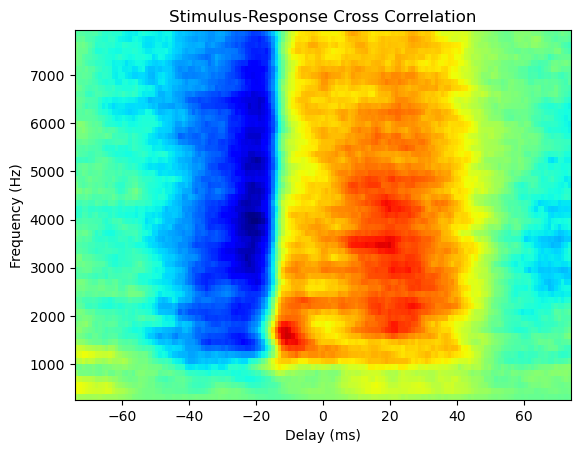

In [12]:
# display the stimulus response cross-correlation
plt.figure()

# Looks at first ds to examine frequencies
ds = srData['datasets'][0]
tfrep = ds['stim']['tfrep']
strfFrequencies = tfrep['f']

crossCorr = np.load(os.path.join(options['outputDir'], 'StimResp_crosscorr.npy'))

maxabs = np.max(np.abs(crossCorr))

plt.imshow(crossCorr, origin='lower', cmap = 'jet', aspect='auto',
           extent=[-strfDelays[-1], strfDelays[-1], strfFrequencies[0], strfFrequencies[-1]],
           vmin=-maxabs,
           vmax=maxabs)

plt.xlabel('Delay (ms)')
plt.ylabel('Frequency (Hz)')
plt.title('Stimulus-Response Cross Correlation')

Text(0.5, 1.0, 'Stimulus Auto Correlation for band 0')

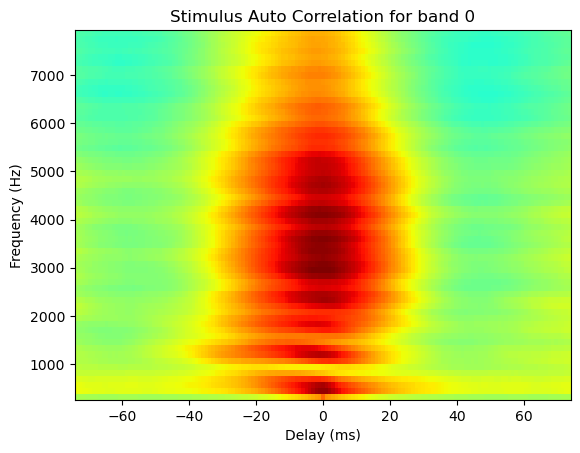

In [13]:
# display the stimulus auto-correlation
plt.figure()

# Looks at first ds to examine frequencies
ds = srData['datasets'][0]
tfrep = ds['stim']['tfrep']
strfFrequencies = tfrep['f']
nbands = modelParams['nIn']

autoCorr = np.load(os.path.join(options['outputDir'], 'Stim_autocorr.npy'))

maxabs = np.max(np.abs(autoCorr[0:nbands,:]))


plt.imshow(autoCorr[0:nbands,:], origin='lower', cmap = 'jet', aspect='auto',
           extent=[-strfDelays[-1], strfDelays[-1], strfFrequencies[0], strfFrequencies[-1]],
           vmin=-maxabs,
           vmax=maxabs)

plt.xlabel('Delay (ms)')
plt.ylabel('Frequency (Hz)')
plt.title('Stimulus Auto Correlation for band 0')

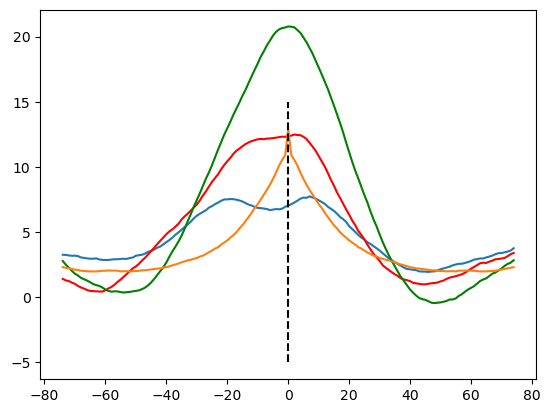

In [14]:
# The stimulus auto-correlations looks ok.

# display the stimulus auto-correlation
plt.figure()

# Looks at first ds to examine frequencies


plt.plot(np.arange(-strfDelays[-1],strfDelays[-1]+1), autoCorr[5,:])
plt.plot(np.arange(-strfDelays[-1],strfDelays[-1]+1), autoCorr[10,:], 'r')
plt.plot(np.arange(-strfDelays[-1],strfDelays[-1]+1), autoCorr[20,:], 'g')
plt.plot(np.arange(-strfDelays[-1],strfDelays[-1]+1), autoCorr[0,:])

plt.plot([0, 0], [-5, 15], 'k--')

Text(0.5, 1.0, 'Best STRF')

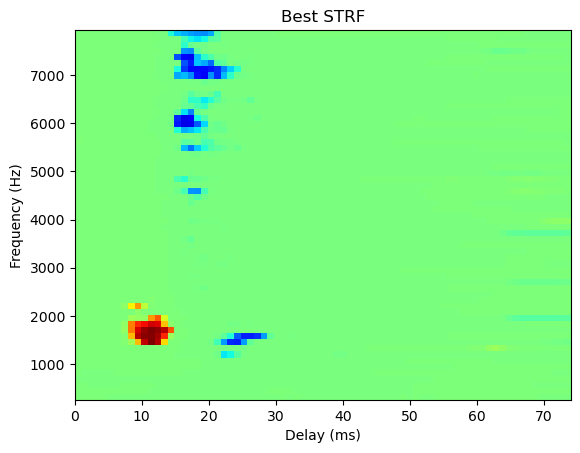

In [16]:
# display the best STRF
plt.figure()

# Looks at first ds to examine frequencies
ds = srData['datasets'][0]
tfrep = ds['stim']['tfrep']
strfFrequencies = tfrep['f']

mySTRF = np.real(modelParamsTrained['w1'])
maxabs = np.max(np.abs(mySTRF))

plt.imshow( mySTRF, origin='lower', cmap = 'jet', aspect='auto',
           extent=[strfDelays[0], strfDelays[-1], strfFrequencies[0], strfFrequencies[-1]],
           vmin=-maxabs,
           vmax=maxabs)

plt.xlabel('Delay (ms)')
plt.ylabel('Frequency (Hz)')
plt.title('Best STRF')

compute prediction for each stim/response pair and concatenate them, <br>
also split the real PSTHs in half and concatenate them across pairs

In [17]:
pairCount = len(srData['datasets'])
predictionSets = [None] * pairCount
concatPredResp = np.array([])
concatPsthHalf1 = np.array([])
concatPsthHalf2 = np.array([])

strfFrequencies = -1

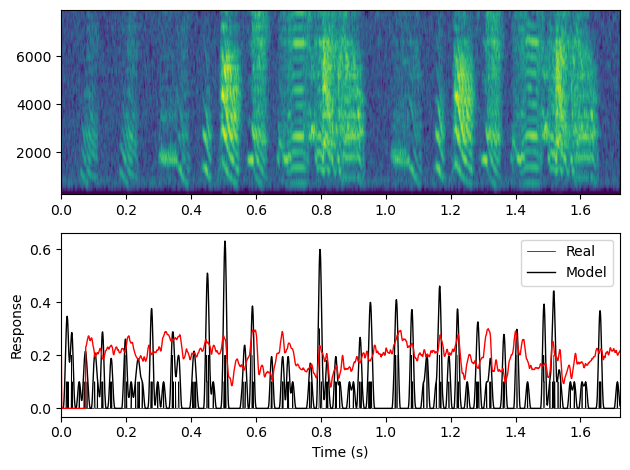

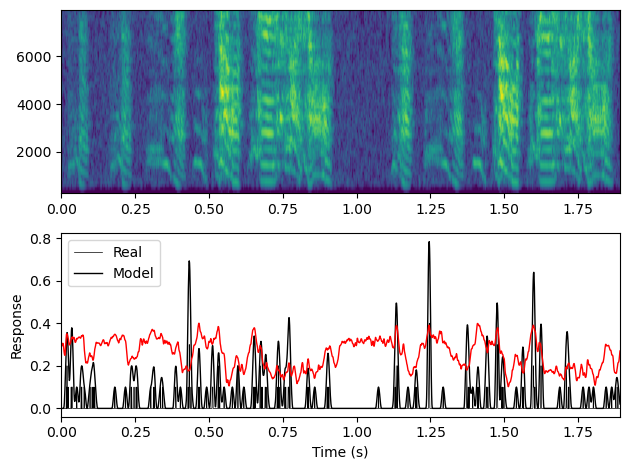

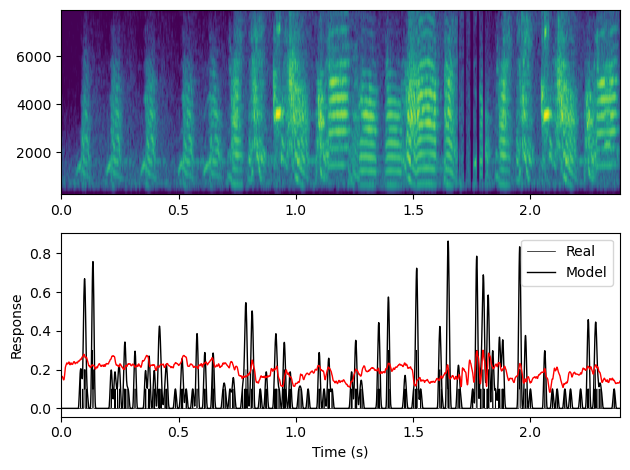

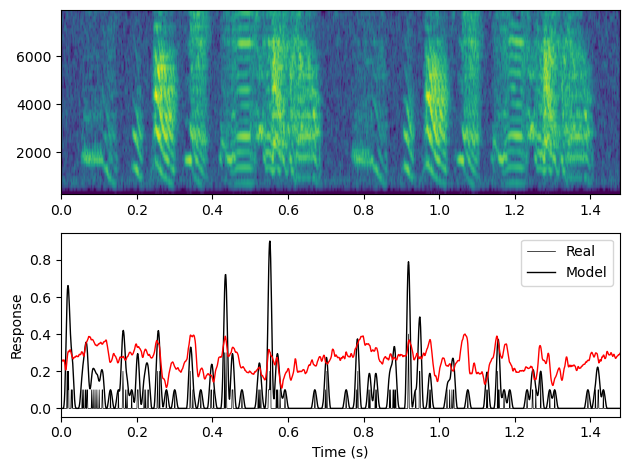

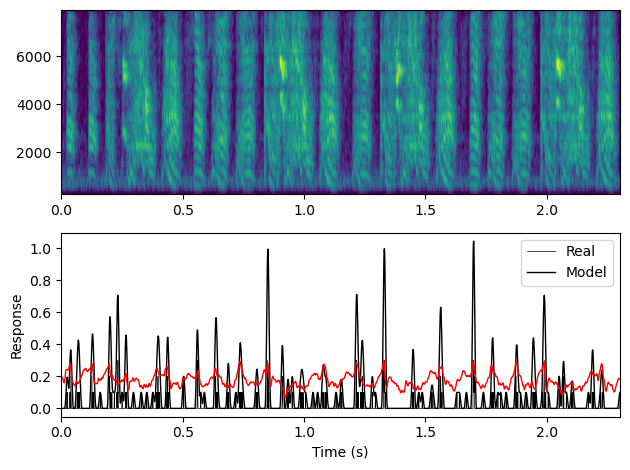

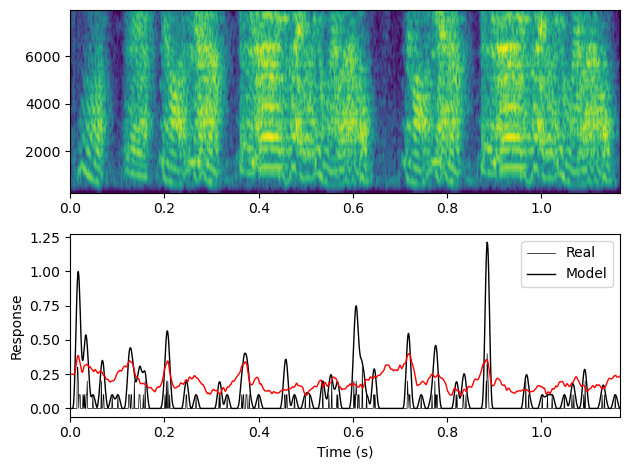

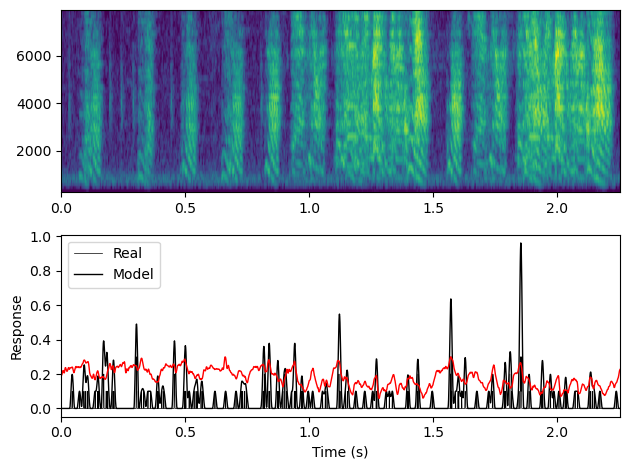

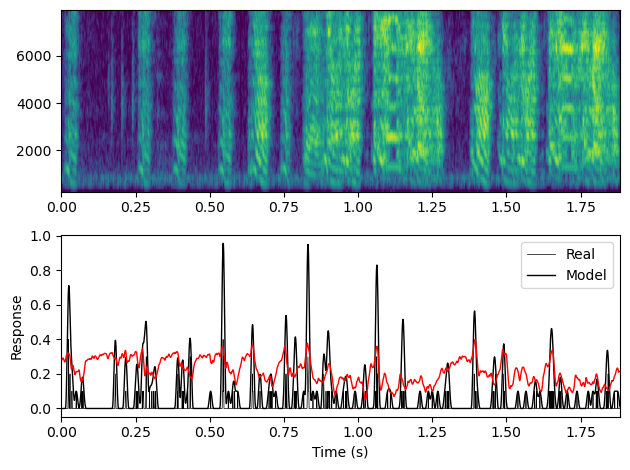

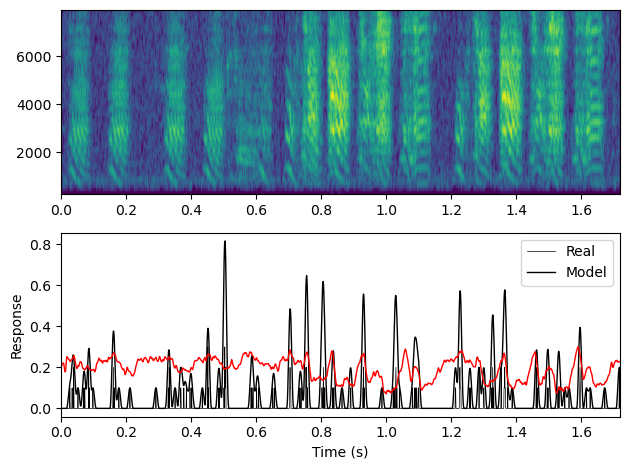

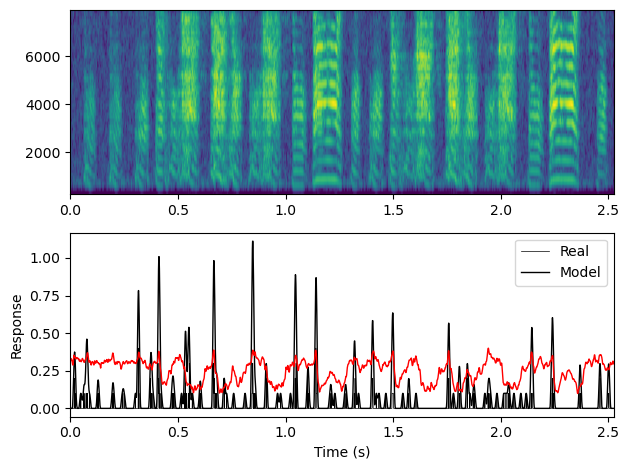

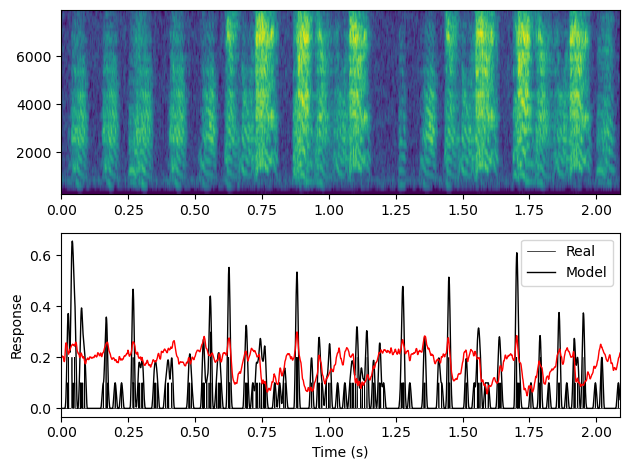

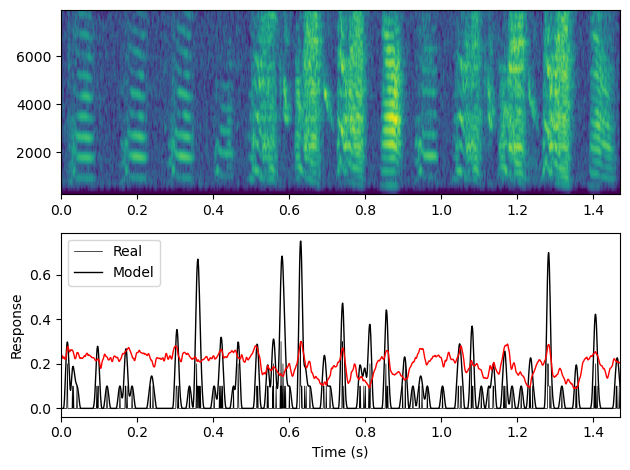

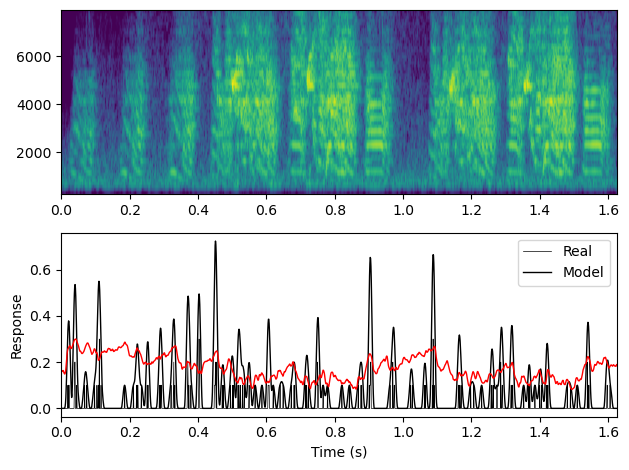

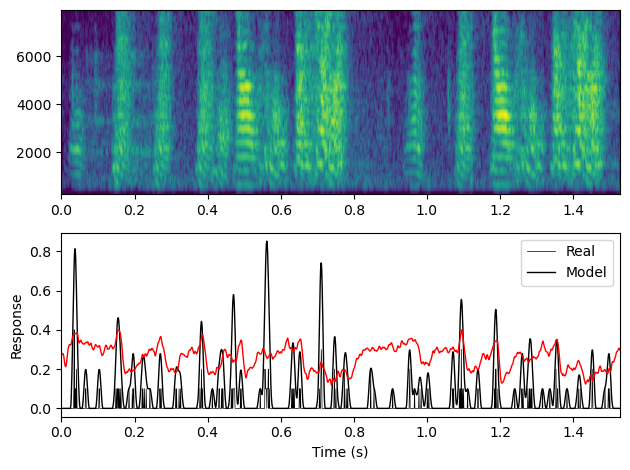

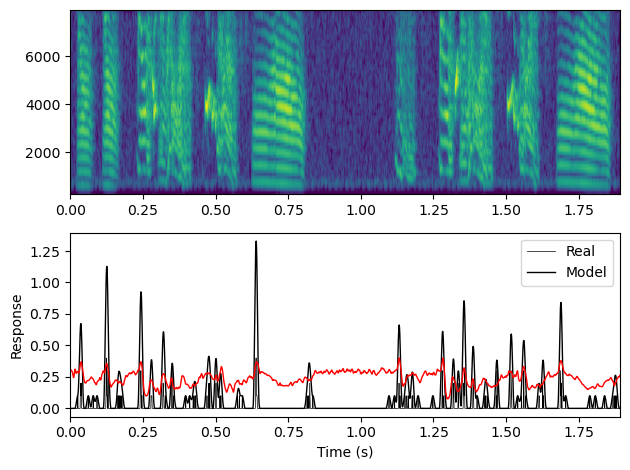

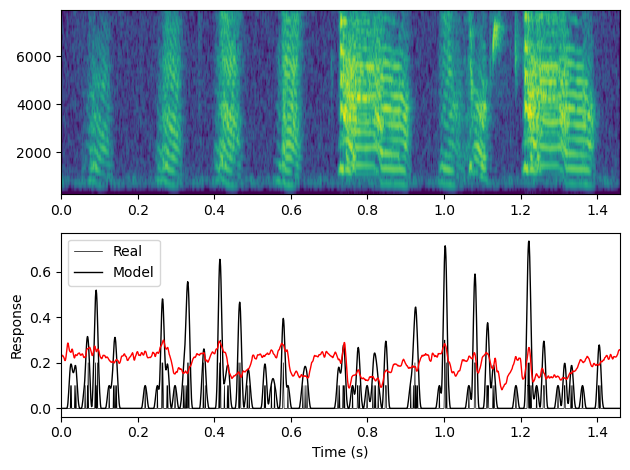

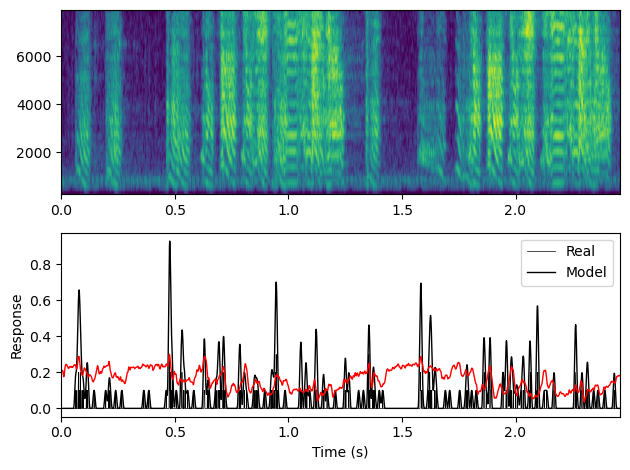

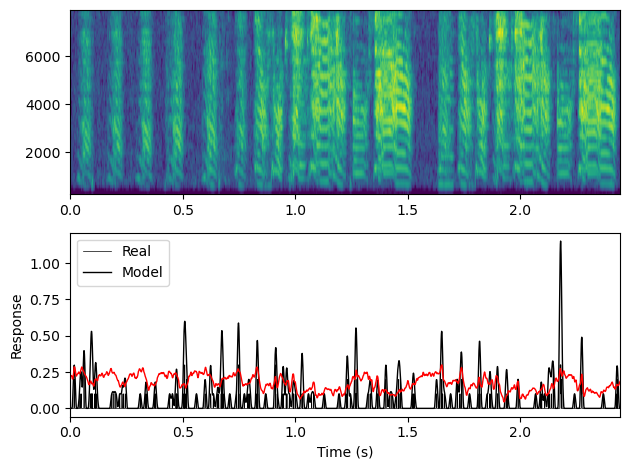

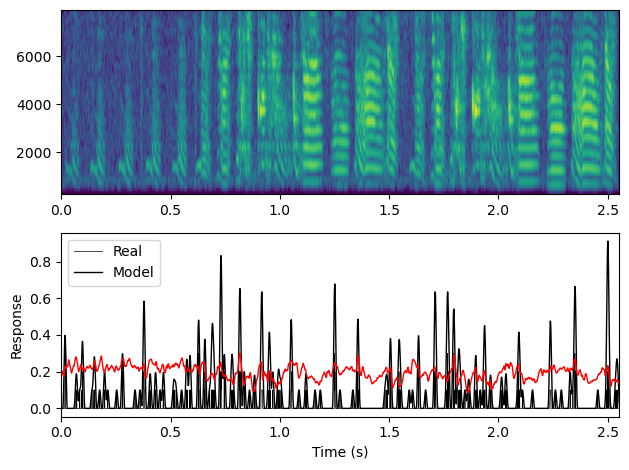

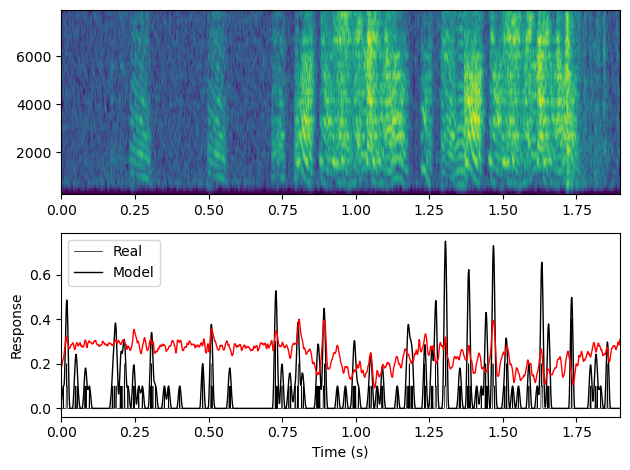

In [21]:
for k in range(pairCount):
    # get stim and response
    ds = srData['datasets'][k]
    tfrep = ds['stim']['tfrep']
    strfFrequencies = tfrep['f']


    strflabIndx = np.where(groupIndex == k)[0]
    stim = allstim[strflabIndx, :]
    resp = allresp[strflabIndx]

    # Smooth the response with a 31 ms window
    wHann = windows.hann(21, sym=True)
    respSmoothed = np.convolve(resp, wHann, mode='same')

    # compute prediction
    modelParamsTemp, predResp = strfSetup.strfFwd(modelParamsTrained, strflabIndx, globDat)
    del modelParamsTemp

    # fix any NaNs in response
    predResp = predResp[0]
    predResp[np.isnan(predResp)] = 0


    # rectify response
    predResp[predResp < 0] = 0

    # scale predicted response
    predResp = (predResp / max(predResp)) * max(resp)

    # concatenate PSTH halves and predicted PSTH for this trial
    stimLengthMs = (stim.shape[0] / srData['stimSampleRate']) * 1e3
    psthdata = preprocSound.split_psth(ds['resp']['rawSpikeIndicies'], stimLengthMs)
    numTrials = len(ds['resp']['rawSpikeTimes'])

    concatPredResp = np.concatenate((concatPredResp, predResp))
    concatPsthHalf1 = np.concatenate((concatPsthHalf1, psthdata['psth_half1']))
    concatPsthHalf2 = np.concatenate((concatPsthHalf2, psthdata['psth_half2']))
    %matplotlib inline
    plt.figure()
    rsint = 1 / srData['respSampleRate']
    tresp = np.arange(len(resp)) * rsint
    tpresp = np.arange(len(predResp)) * rsint

    plt.subplot(2,1,1)
    plt.imshow(tfrep['spec'], aspect='auto', origin='lower'
           , extent=[tfrep['t'][0], tfrep['t'][-1], tfrep['f'][0], tfrep['f'][-1]])

    

    # plot response and prediction
    plt.subplot(2,1,2)
    plt.plot(tresp, resp, 'k-', linewidth=0.5)
    plt.plot(tresp, respSmoothed, 'k-', linewidth=1)
    plt.plot(tpresp, predResp, 'r-', linewidth=1)
    plt.legend(['Real', 'Model'])
    plt.xlim([tresp[0], tresp[-1]])
    plt.xlabel('Time (s)')
    plt.ylabel('Response')
    plt.tight_layout()
    plt.show()

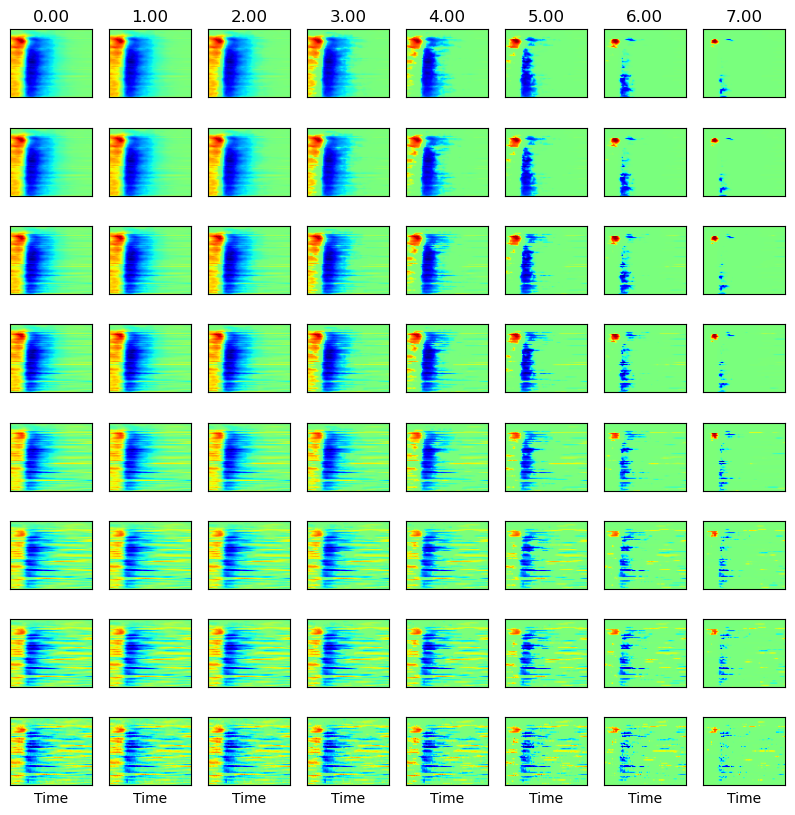

In [23]:
%matplotlib inline
# Create a list of file names for each tolerance
strfFiles = [os.path.join(options['outputDir'], f'strfResult_Tol{k}.npz') for k in range(1, len(options['tolerances']) + 1)]

# Choose the temporal section of the STRF that is used in the convolution
halfIndx = int(np.ceil(np.max(np.abs(modelParams['delays']))) + 1)  # This is the point corresponding to zero
startIndx = int(halfIndx + round(np.min(modelParams['delays'])))
endIndx = int(halfIndx + round(np.max(modelParams['delays'])))
# strfRng = np.arange(startIndx, endIndx)

fig, axs = plt.subplots(len(options['tolerances']), len(options['sparsenesses']), figsize=(10, 10))
maxall = np.zeros((len(options['tolerances']), len(options['sparsenesses'])))

for k in range(len(options['tolerances'])):

    svars = np.load(strfFiles[k], allow_pickle=True)
    strfsJN = svars['STRFJN_Cell']
    strfsJN_std = svars['STRFJNstd_Cell']
    strfMean = svars['STRF_Cell']
    strfStdMean = np.mean(strfsJN_std, axis=2)
    
    # Clear the variable to free up memory
    del svars
    
    for q in range(len(options['sparsenesses'])):
        ax = axs[k, q]
        
        smoothedMeanStrf = trnDirectFit.df_fast_filter_filter(strfMean, strfStdMean, options['sparsenesses'][q])
        # smoothedMeanStrf = strfMean

        im = ax.imshow(np.real(smoothedMeanStrf[:, startIndx:endIndx+1])
                       , cmap='jet'
                       , vmin=-np.max(np.abs(np.real(smoothedMeanStrf[:, startIndx:endIndx+1])))
                       , vmax=np.max(np.abs(np.real(smoothedMeanStrf[:, startIndx:endIndx+1])))
                      )
        maxall[k, q] = np.max(np.abs(np.real(smoothedMeanStrf[:, startIndx:endIndx+1])))
        
        # fig.colorbar(im, ax=ax)
        # im.set_clim(-maxall[k, q], maxall[k, q])
        ax.set_xticks([])
        ax.set_yticks([])
        if k == 0:
            ax.set_title('%.2f' % options['sparsenesses'][q])
        if k == len(options['tolerances']) - 1:
            ax.set_xlabel('Time')

        

plt.show()


In [ ]:
import pickle 
pickle.dump(modelParams,open("/tmp/modelParams.pkl",'wb'))
pickle.dump(datIdx,open("/tmp/datIdx.pkl",'wb'))
pickle.dump(optOptions,open("/tmp/optOptions.pkl",'wb'))
pickle.dump(globDat,open("/tmp/globDat.pkl",'wb'))

In [ ]:
tmp_modelParams = pickle.load(open("/tmp/modelParams.pkl",'rb'))
tmp_datIdx = pickle.load(open("/tmp/datIdx.pkl",'rb'))
tmp_optOptions = pickle.load(open("/tmp/optOptions.pkl",'rb'))
tmp_globDat = pickle.load(open("/tmp/globDat.pkl",'rb'))